In [1]:

from IPython.display import display, Markdown, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))


In [2]:
import math
import glob
import ROOT
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import pylab as plt
import yaml
import base64
import ctypes
import logging
import bokeh
import os
import sys
import pytest
from RootInteractive.Tools.aliTreePlayer import *
from bokeh.io import curdoc
from bokeh.io import output_notebook, show
from pandas import CategoricalDtype
from bokeh.models import ColumnDataSource, OpenURL, TapTool
from bokeh.plotting import figure, output_file, show
from RootInteractive.InteractiveDrawing.bokeh.bokehDrawSA import *
from RootInteractive.InteractiveDrawing.bokeh.bokehTools import bokehDrawArray
from RootInteractive.Tools.pandaTools import initMetadata
from RootInteractive.Tools.aliTreePlayer import *
from RootInteractive.Tools.compressArray import arrayCompressionRelative8

output_notebook()

Welcome to JupyROOT 6.24/06
x bokehVisJS3DGraph.ts
x HistogramCDS.ts
Import  CDSCompress.ts
Import  DownsamplerCDS.ts
Import  CDSAlias.ts
Import  CDSJoin.ts


Loading BokehJS ...

# Display skimmed AO2D tracks
In this notebook a RootInteractive dashboard is created for interactive investigation of skimmed AO2D tracks.

## Used data
We are using AO2D tracks data from the 2021 Pilot beam
Skimming is done on O2Physics side and only the skimmed tracks file is imported into the notebook

In [3]:
path = "/Users/anjaly/TPCQCVis/data/examples/SkimmedTrackFiles"
fileList = glob.glob(path+"/skimmed_LHC22c_*_001.root")
fileList.sort()
runList = [fileList[i][len(path)+16:-9] for i in range(len(fileList))]
runList = list(map(int, runList))
print(runList)


[517618, 517619, 517620, 517623, 517677, 517678, 517684, 517685, 517689, 517690, 517692, 517693, 517737]


In [4]:
df = pd.DataFrame()
i=0
for f in fileList:
    #print(f)
    f=ROOT.TFile.Open(f)
    tracks = f.Get("tracks")
    tracks.SetAlias("weight1","((triggerMask&0x1)>0)*100*max(weight,0.01)")
    tracks.SetAlias("weight2","((triggerMask&0x2)>0)*100*max(weight*pt*pt,0.01)")
    tracks.SetAlias("weight3","((triggerMask&0x4)>0)*100")
    tracks.SetAlias("weight_full","weight1+weight2+weight3")
    tracks.SetAlias("rMin","trackPar.mX")
    tracks.SetAlias("qPt","trackPar.mP[4]")
    tracks.SetAlias("pzPt","trackPar.mP[3]")
    tracks.SetAlias("itsOn","itsClusterMap>0")
    tracks.SetAlias("tofOn","abs(tofChi2)<100")
    tracks.SetAlias("p","pt*sqrt(1+pzPt*pzPt)")
    tracks.SetAlias("logp","log(p)")
    #tracks.SetAlias("logtpcSignal","log(tpcSignal)")
    tracks.SetAlias("eta","trackPar.getEta()")
    tracks.SetAlias("theta","trackPar.getTheta()")
    tracks.SetAlias("tgl","trackPar.getTgl()")
    tracks.SetAlias("snp","trackPar.getSnp()")
    df_tmp=tree2Panda(tracks, [".*"], "", exclude=["trackPar"])
    df_tmp=df_tmp[df_tmp['pt'].values<20]
    df_tmp["dcaDefined"]=df_tmp.eval("dcaXY!=0")
    df_tmp["side"]=df_tmp.eval("pzPt>0") ##  (A/C/CrossAC/CrossCA side)
    df_tmp["isPrim5"]=df_tmp.eval("abs(dcaXY)<5 &  abs(dcaZ)<5 & rMin<5")
    df_tmp["dcaDefined"]=df_tmp.eval("dcaXY!=0")
    df_tmp["side"]=df_tmp.eval("pzPt>0") ##  (A/C/CrossAC/CrossCA side)
    df_tmp["isPrim5"]=df_tmp.eval("abs(dcaXY)<5 &  abs(dcaZ)<5 & rMin<5")
    df_tmp["tpcNCR"]=df_tmp["tpcNClsFindable"]-df_tmp["tpcNClsFindableMinusCrossedRows"]
    #df_tmp["tpcNCR"]=df_tmp["tpcNClsFindable"]-df_tmp["tpcNClsFindableMinusCrossedRows"]
    # deleting unused columns
    df_tmp.drop("tofExpMom", inplace=True, axis=1)
    df_tmp.drop("itsChi2NCl", inplace=True, axis=1)
    df_tmp.drop("trdPattern", inplace=True, axis=1)
    df_tmp.drop("vertex_", inplace=True, axis=1)
    df_tmp.drop("trackEtaEmcal", inplace=True, axis=1)
    df_tmp.drop("tpcNClsShared", inplace=True, axis=1)
    df_tmp.drop("flags", inplace=True, axis=1)
    df_tmp.drop("tpcNClsFindableMinusFound", inplace=True, axis=1)
    df_tmp.drop("trdChi2", inplace=True, axis=1)
    df_tmp.drop("trackPhiEmcal", inplace=True, axis=1)
    df_tmp.drop("tofChi2", inplace=True, axis=1)
    #print(runList[i])
    df_tmp["runNumber"]=runList[i]
    #print(i)
    i=i+1
    df=pd.concat([df,df_tmp], ignore_index=True)
display(df)


,weight3,pzPt,trackTimeRes,trackTime,itsClusterMap,itsOn,length,weight_full,tofOn,pt,...,eta,qPt,tpcNClsFindableMinusCrossedRows,weight,dcaZ,dcaDefined,side,isPrim5,tpcNCR,runNumber
0,0.0,0.115602,0.199997,9.326105e+00,0,0.0,480.007812,2.000000,1.0,9.545699,...,0.115346,-0.104759,-11,0.000029,999.000000,True,True,False,95,517618
1,0.0,-0.000041,47021.000000,-4.282963e+04,0,0.0,-999.000000,1.000000,0.0,0.028780,...,-0.000041,34.746094,-13,6.970708,999.000000,True,False,False,24,517618
2,0.0,-0.000003,47021.000000,-4.282963e+04,0,0.0,-999.000000,2.653502,0.0,2.492053,...,-0.000003,-0.401276,-19,0.026535,0.000147,True,False,False,92,517618
3,0.0,-0.000001,47021.000000,-4.282963e+04,0,0.0,-999.000000,2.000000,0.0,11.113447,...,-0.000001,-0.089981,-8,0.000013,0.000002,True,False,True,152,517618
4,0.0,-0.000018,47021.000000,-4.282963e+04,0,0.0,-999.000000,4.891518,0.0,2.173809,...,-0.000018,0.460022,-31,0.048915,0.002373,True,False,False,95,517618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1376429,0.0,0.000306,47070.000000,-2.403772e+06,0,0.0,-999.000000,1.000000,0.0,0.025506,...,0.000306,39.207031,-8,6.215415,999.000000,True,True,False,23,517737
1376430,100.0,-1.026215,16752.000000,1.453588e+04,0,0.0,-999.000000,100.000000,0.0,0.493316,...,-0.899789,-2.027100,-26,6.623789,-15.515330,True,False,False,153,517737
1376431,0.0,0.000121,47070.000000,-5.842610e+05,0,0.0,-999.000000,5.145660,0.0,0.061642,...,0.000121,-16.222656,-7,13.542070,999.000000,True,True,False,25,517737
1376432,0.0,0.491272,44698.000000,7.036692e+03,0,0.0,-999.000000,3.771417,0.0,0.055131,...,0.473392,-18.138672,-15,12.408391,999.000000,True,True,False,28,517737


In [5]:

df.head()

,weight3,pzPt,trackTimeRes,trackTime,itsClusterMap,itsOn,length,weight_full,tofOn,pt,...,eta,qPt,tpcNClsFindableMinusCrossedRows,weight,dcaZ,dcaDefined,side,isPrim5,tpcNCR,runNumber
0,0.0,0.115602,0.199997,9.326105,0,0.0,480.007812,2.000000,1.0,9.545699,...,0.115346,-0.104759,-11,0.000029,999.000000,True,True,False,95,517618
1,0.0,-0.000041,47021.000000,-42829.632812,0,0.0,-999.000000,1.000000,0.0,0.028780,...,-0.000041,34.746094,-13,6.970708,999.000000,True,False,False,24,517618
2,0.0,-0.000003,47021.000000,-42829.632812,0,0.0,-999.000000,2.653502,0.0,2.492053,...,-0.000003,-0.401276,-19,0.026535,0.000147,True,False,False,92,517618
3,0.0,-0.000001,47021.000000,-42829.632812,0,0.0,-999.000000,2.000000,0.0,11.113447,...,-0.000001,-0.089981,-8,0.000013,0.000002,True,False,True,152,517618
4,0.0,-0.000018,47021.000000,-42829.632812,0,0.0,-999.000000,4.891518,0.0,2.173809,...,-0.000018,0.460022,-31,0.048915,0.002373,True,False,False,95,517618


In [6]:
df.tail()

,weight3,pzPt,trackTimeRes,trackTime,itsClusterMap,itsOn,length,weight_full,tofOn,pt,...,eta,qPt,tpcNClsFindableMinusCrossedRows,weight,dcaZ,dcaDefined,side,isPrim5,tpcNCR,runNumber
1376429,0.0,0.000306,47070.0,-2.403772e+06,0,0.0,-999.0,1.000000,0.0,0.025506,...,0.000306,39.207031,-8,6.215415,999.000000,True,True,False,23,517737
1376430,100.0,-1.026215,16752.0,1.453588e+04,0,0.0,-999.0,100.000000,0.0,0.493316,...,-0.899789,-2.027100,-26,6.623789,-15.515330,True,False,False,153,517737
1376431,0.0,0.000121,47070.0,-5.842610e+05,0,0.0,-999.0,5.145660,0.0,0.061642,...,0.000121,-16.222656,-7,13.542070,999.000000,True,True,False,25,517737
1376432,0.0,0.491272,44698.0,7.036692e+03,0,0.0,-999.0,3.771417,0.0,0.055131,...,0.473392,-18.138672,-15,12.408391,999.000000,True,True,False,28,517737
1376433,0.0,0.117363,43054.0,-9.795854e+03,0,0.0,-999.0,67.042061,0.0,0.184057,...,0.117095,5.433111,-12,19.789939,-28.798784,True,True,False,148,517737


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1376434 entries, 0 to 1376433
Data columns (total 36 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   weight3                          1376434 non-null  float64
 1   pzPt                             1376434 non-null  float64
 2   trackTimeRes                     1376434 non-null  float32
 3   trackTime                        1376428 non-null  float32
 4   itsClusterMap                    1376434 non-null  int16  
 5   itsOn                            1376434 non-null  float64
 6   length                           1376434 non-null  float32
 7   weight_full                      1376434 non-null  float64
 8   tofOn                            1376434 non-null  float64
 9   pt                               1376434 non-null  float32
 10  triggerMask                      1376434 non-null  int32  
 11  logp                             1376434 non-null 

In [8]:
df_Mean = df.mean(axis=0)
df_Mean

weight3                            1.813382e+01
pzPt                               1.065056e-02
trackTimeRes                       2.921578e+04
trackTime                         -2.951931e+10
itsClusterMap                      2.052399e+01
itsOn                              1.885822e-01
length                            -8.814796e+02
weight_full                        5.427523e+01
tofOn                              8.077322e-02
pt                                 1.461553e+00
triggerMask                        2.357788e+00
logp                              -1.242566e+00
tpcNClsFindable                    7.178249e+01
phi                                3.028550e+00
dcaXY                              3.818146e+02
tgl                                1.065056e-02
tpcChi2NCl                        -8.056378e+00
theta                              1.562038e+00
hasCollision                       4.893471e-01
tpcSignal                          6.833056e+01
trdSignal                         -9.990

In [9]:
print(df['pt'].where(df['pt'] < 1))

0               NaN
1          0.028780
2               NaN
3               NaN
4               NaN
             ...   
1376429    0.025506
1376430    0.493316
1376431    0.061642
1376432    0.055131
1376433    0.184057
Name: pt, Length: 1376434, dtype: float32


In [10]:
print(df['pt'].max())

19.99878


In [11]:
df_Median = df.median(axis=0)
df_Median



weight3                                 0.000000
pzPt                                    0.000047
trackTimeRes                        37989.000000
trackTime                           -1207.894043
itsClusterMap                           0.000000
itsOn                                   0.000000
length                               -999.000000
weight_full                             9.553902
tofOn                                   0.000000
pt                                      0.146244
triggerMask                             2.000000
logp                                   -1.759342
tpcNClsFindable                        76.000000
phi                                     2.982437
dcaXY                                  13.686806
tgl                                     0.000047
tpcChi2NCl                              1.367188
theta                                   1.570749
hasCollision                            0.000000
tpcSignal                              56.145508
trdSignal           

In [12]:
# Adding the variable mean Trend  vs Run number 
# 0. Read all the input file 
# 1. Run number is an integer assign to the last column of datafarm
# 2. Create a cut on data frame based on runnumber condition 
# 3. Take the mean() of the cut data frame with specific run number 
# 4. append them together in the loop --> Discussion 
# 5. We will have a new Data frame 

In [13]:
def mean(df,runList):
    dfs = {}
    j=1
    df_trend_mean = df.drop(df.index)
    temp_df = df.drop(df.index)
    df2 = df.drop(df.index) 
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    for i in runList:
        #print(i)
        temp_df = df[df['runNumber']==i]
        df3 = temp_df.mean(axis = 0, skipna = True).reset_index()
        df2=df3.T
        if j != 1: df2 = df2.iloc[1:]
        dfs[j]= df2
        j=j+1
    df_trend = pd.concat(dfs,ignore_index=True)
    df_trend = df_trend.iloc[0: , :]
    display(df_trend)
    return df_trend_mean

In [14]:
def median(df,runList):
    dfs = {}
    j=1
    #print(runList)
    df_trend_mean = df.drop(df.index)
    temp_df = df.drop(df.index)
    df2 = df.drop(df.index) 
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    for i in runList:
        print(i)
        temp_df = df[df['runNumber']==i]
        df3 = temp_df.median(axis = 0, skipna = True).reset_index()
        df2=df3.T
        if j != 1: df2 = df2.iloc[1:]
        dfs[j]= df2
        j=j+1
    df_trend = pd.concat(dfs,ignore_index=True)
    df_trend = df_trend.iloc[0: , :]
    display(df_trend)
    return df_trend_mean

In [15]:
mean(df,runList)


,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,weight3,pzPt,trackTimeRes,trackTime,itsClusterMap,itsOn,length,weight_full,tofOn,pt,...,eta,qPt,tpcNClsFindableMinusCrossedRows,weight,dcaZ,dcaDefined,side,isPrim5,tpcNCR,runNumber
1,20.207,0.0177374,26637.9,-147652,28.1175,0.257047,-888.046,60.8452,0.0764444,1.28084,...,0.0152658,0.328557,-10.5236,10.4099,316.968,1,0.527582,0.304285,87.3575,517618
2,20.072,0.0196854,26678.5,-144683,27.9573,0.254846,-882.21,59.8927,0.0804597,1.29876,...,0.0159234,0.184261,-10.5267,10.3507,324.4,1,0.526549,0.299673,86.8306,517619
3,18.9034,0.021008,28899.6,-221564,24.6698,0.229147,-934.525,56.3264,0.0444046,1.41242,...,0.0174015,0.1181,-10.5185,10.1717,354.09,1,0.527772,0.274948,84.3485,517620
4,16.7861,0.0132078,29540.8,-304809,21.3066,0.195828,-879.07,50.4078,0.082352,1.55631,...,0.0123295,0.071698,-10.401,9.8731,409.437,1,0.531324,0.233249,79.7993,517623
5,20.1299,0.0126673,26540,-2.14501e+12,29.3296,0.254567,-877.214,61.796,0.0839404,1.31853,...,0.0139034,0.322552,-10.5775,10.3202,321.321,1,0.524021,0.302238,88.203,517677
6,19.3668,0.0260144,27313.8,-137335,28.3783,0.245674,-879.644,58.6755,0.0819547,1.32234,...,0.0230851,0.103951,-10.5022,10.2739,345.135,1,0.53841,0.290454,85.6833,517678
7,19.6721,0.0170331,32685.1,-200106,5.06193,0.0874317,-894.961,41.5699,0.0710383,1.44472,...,0.00992172,0.740843,-10.0273,10.4783,455.267,1,0.535519,0.17122,76.4226,517684
8,15.1648,-0.0196758,31295.8,-301492,17.933,0.155191,-859.597,44.139,0.0956655,1.68665,...,-0.0118776,-0.337441,-10.424,9.75042,477.529,1,0.523798,0.191213,74.6622,517685
9,16.3501,-0.0168949,34410.9,-272476,0,0,-862.786,48.7652,0.0933071,1.65878,...,-0.0124559,-0.0977888,-10.3688,9.97116,470.776,1,0.521246,0.161409,76.5844,517689


,weight3,pzPt,trackTimeRes,trackTime,itsClusterMap,itsOn,length,weight_full,tofOn,pt,...,eta,qPt,tpcNClsFindableMinusCrossedRows,weight,dcaZ,dcaDefined,side,isPrim5,tpcNCR,runNumber


Start a new framework using Pivot Table:

In [16]:
df_mean=df.pivot_table(index='runNumber').reset_index()
df_mean['runList'] = runList
df_mean['Links']= ["https://google.com" for i in range(len(fileList))]
display(df_mean)

,runNumber,dcaDefined,dcaXY,dcaZ,eta,hasCollision,isPrim5,itsClusterMap,itsOn,length,...,trackTimeRes,trdSignal,triggerMask,weight,weight1,weight2,weight3,weight_full,runList,Links
0,517618,1.0,316.038116,316.968048,0.015266,0.661623,0.304285,28.117509,0.257047,-888.045959,...,26637.875000,-999.0,2.372950,10.409913,20.266737,20.371443,20.206985,60.845165,517618,https://google.com
1,517619,1.0,323.304016,324.400269,0.015923,0.648647,0.299673,27.957321,0.254846,-882.209534,...,26678.455078,-999.0,2.372844,10.350723,19.773449,20.047203,20.072021,59.892673,517619,https://google.com
2,517620,1.0,353.164459,354.089844,0.017402,0.604541,0.274948,24.669847,0.229147,-934.524902,...,28899.599609,-999.0,2.362884,10.171738,18.560048,18.862909,18.903442,56.326398,517620,https://google.com
3,517623,1.0,408.208862,409.437256,0.012330,0.516349,0.233249,21.306611,0.195828,-879.069946,...,29540.822266,-999.0,2.341885,9.873102,16.696809,16.924890,16.786065,50.407764,517623,https://google.com
4,517677,1.0,319.194733,321.320923,0.013903,0.649562,0.302238,29.329585,0.254567,-877.214050,...,26539.984375,-999.0,2.373878,10.320199,21.413424,20.252704,20.129870,61.795998,517677,https://google.com
5,517678,1.0,344.388885,345.134705,0.023085,0.619509,0.290454,28.378304,0.245674,-879.644226,...,27313.843750,-999.0,2.372980,10.273943,20.134850,19.173846,19.366800,58.675496,517678,https://google.com
6,517684,1.0,452.873718,455.267395,0.009922,0.437158,0.171220,5.061931,0.087432,-894.961182,...,32685.128906,-999.0,2.451730,10.478322,3.857516,18.040214,19.672131,41.569861,517684,https://google.com
7,517685,1.0,474.760498,477.529358,-0.011878,0.406283,0.191213,17.933034,0.155191,-859.597473,...,31295.832031,-999.0,2.339317,9.750417,14.659601,14.314651,15.164757,44.139009,517685,https://google.com
8,517689,1.0,464.943817,470.776276,-0.012456,0.000000,0.161409,0.000000,0.000000,-862.786011,...,34410.882812,-999.0,2.353680,9.971163,16.022879,16.392205,16.350111,48.765194,517689,https://google.com
9,517690,1.0,490.113403,492.924805,0.001408,0.367714,0.171308,16.178438,0.141861,-860.093567,...,31745.072266,-999.0,2.321354,9.563059,15.045069,13.992227,13.751319,42.788614,517690,https://google.com


[Text(0, 0, '517618'),
 Text(1, 0, '517619'),
 Text(2, 0, '517620'),
 Text(3, 0, '517623'),
 Text(4, 0, '517677'),
 Text(5, 0, '517678'),
 Text(6, 0, '517684'),
 Text(7, 0, '517685'),
 Text(8, 0, '517689'),
 Text(9, 0, '517690'),
 Text(10, 0, '517692'),
 Text(11, 0, '517693'),
 Text(12, 0, '517737')]

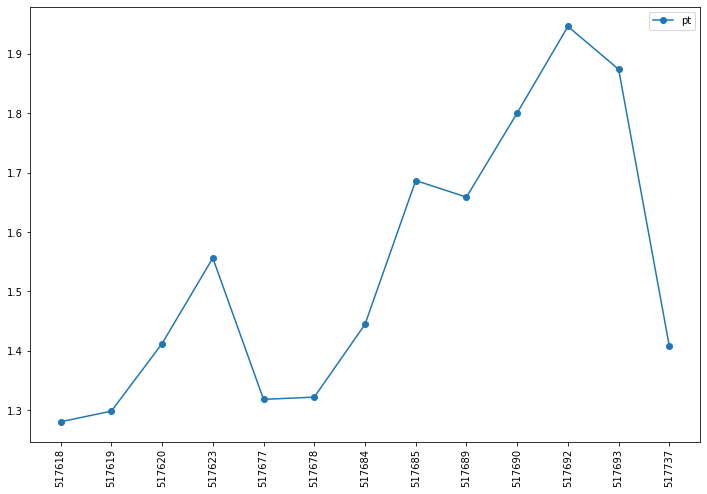

In [17]:
fig = df_mean.plot(y=['pt'],marker='o',figsize=(12, 8))
fig.set_xticks(np.arange(0,len(runList),1))
fig.set_xticklabels(df_mean.runList, rotation=90)

<AxesSubplot:xlabel='runNumber'>

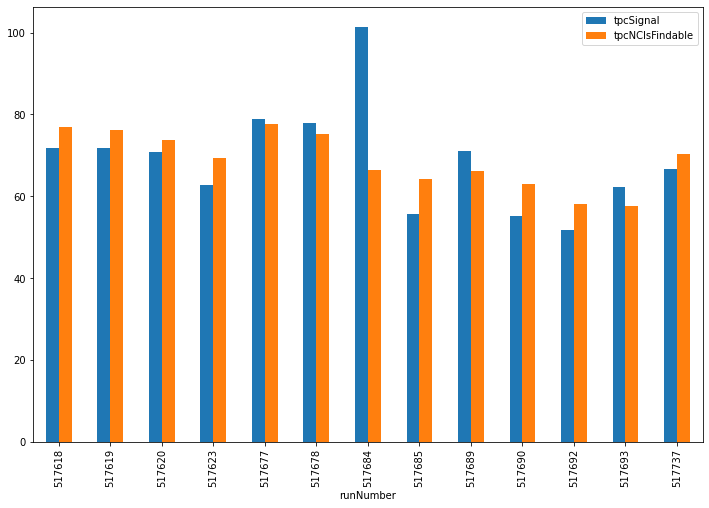

In [18]:
df_mean.plot.bar(x='runNumber', y=['tpcSignal','tpcNClsFindable'], rot =90,figsize=(12, 8))

[Text(0, 0, '517618'),
 Text(1, 0, '517619'),
 Text(2, 0, '517620'),
 Text(3, 0, '517623'),
 Text(4, 0, '517677'),
 Text(5, 0, '517678'),
 Text(6, 0, '517684'),
 Text(7, 0, '517685'),
 Text(8, 0, '517689'),
 Text(9, 0, '517690'),
 Text(10, 0, '517692'),
 Text(11, 0, '517693'),
 Text(12, 0, '517737')]

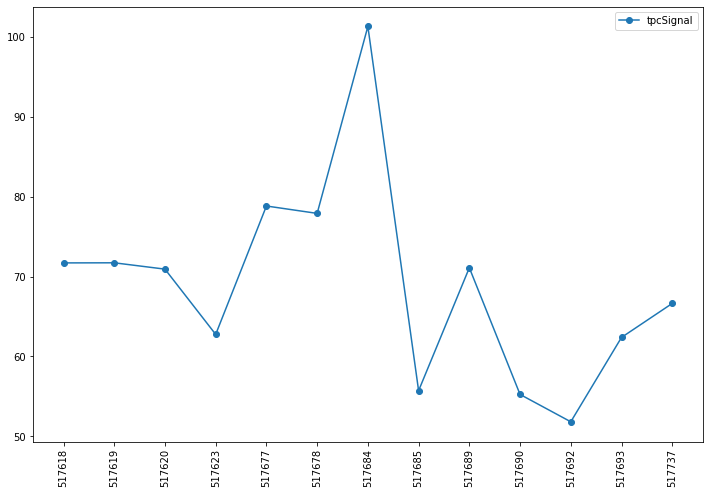

In [19]:
fig1 = df_mean.plot(y=['tpcSignal'],marker='o',figsize=(12, 8))
fig1.set_xticks(np.arange(0,len(runList),1))
fig1.set_xticklabels(df_mean.runList, rotation=90)

<AxesSubplot:xlabel='runNumber'>

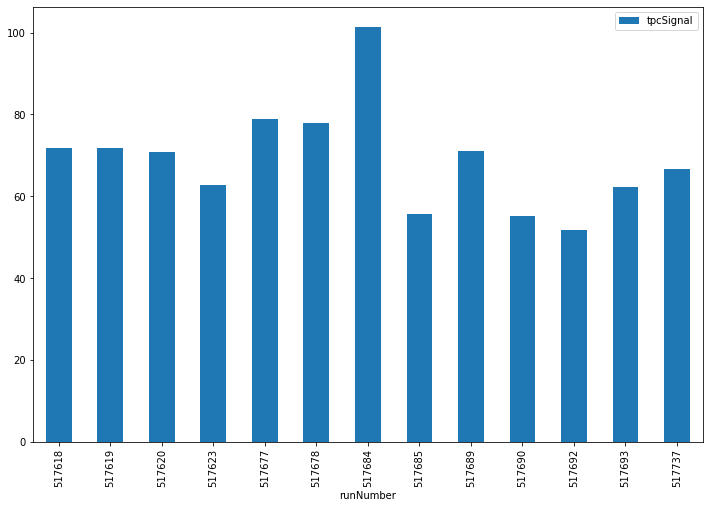

In [20]:
df_mean.plot.bar(x='runNumber', y='tpcSignal', rot =90,figsize=(12, 8))

In [21]:
#df_med=df.pivot_table(index='runNumber',aggfunc=np.median).reset_index()
#df_med

In [22]:
df_std=df.pivot_table(index='runNumber',aggfunc='std').reset_index()
df_std['runList'] = runList
display(df_std)

,runNumber,dcaDefined,dcaXY,dcaZ,eta,hasCollision,isPrim5,itsClusterMap,itsOn,length,...,trackTime,trackTimeRes,trdSignal,triggerMask,weight,weight1,weight2,weight3,weight_full,runList
0,517618,0.0,465.005709,466.096965,0.637259,0.473159,0.460105,51.292299,0.437007,385.874270,...,4.687328e+05,19855.859948,0.0,0.987631,7.332650,157.693459,39.326259,40.154504,160.310318,517618
1,517619,0.0,467.803450,468.750971,0.634995,0.477394,0.458116,51.212517,0.435775,395.048916,...,4.683697e+05,19906.998509,0.0,0.987424,7.317565,155.235230,39.051900,40.053971,157.992956,517619
2,517620,0.0,478.148395,478.888427,0.617901,0.488951,0.446490,48.755090,0.420286,299.261899,...,6.435752e+05,19299.208245,0.0,0.968867,7.285264,150.744450,37.896648,39.153776,153.894177,517620
3,517623,0.0,491.597347,492.433054,0.583311,0.499733,0.422900,46.109287,0.396837,400.578549,...,9.133550e+05,19571.262111,0.0,0.942953,7.192993,143.759793,35.822021,37.374308,147.520773,517623
4,517677,0.0,466.077057,466.460300,0.629775,0.477120,0.459240,52.613204,0.435629,402.571619,...,1.890294e+13,19919.432986,0.0,0.985728,7.342636,164.046657,39.172392,40.098132,166.303953,517677
5,517678,0.0,475.617700,476.686612,0.623326,0.485531,0.453994,52.057543,0.430507,399.730719,...,4.192559e+05,19912.764963,0.0,0.989620,7.279223,156.658207,37.931774,39.519053,159.197959,517678
6,517684,0.0,498.706972,499.311679,0.595054,0.496488,0.377045,21.295021,0.282724,376.781828,...,4.778607e+05,17272.249650,0.0,0.943641,6.816244,53.601965,37.667596,39.788239,70.072996,517684
7,517685,0.0,499.409276,499.107413,0.536197,0.491168,0.393280,43.520910,0.362108,428.857200,...,7.800902e+05,19347.796659,0.0,0.902666,7.027432,129.485651,32.475093,35.870013,133.670887,517685
8,517689,0.0,498.960313,497.117340,0.543016,0.000000,0.367909,0.000000,0.000000,424.902483,...,6.916228e+05,16070.938776,0.0,0.928067,7.192422,140.685260,34.955762,36.982309,144.554953,517689
9,517690,0.0,500.190812,500.308360,0.536058,0.482191,0.376784,41.581572,0.348914,428.392002,...,1.080738e+06,19163.622696,0.0,0.895218,7.011104,137.835253,32.143945,34.439382,141.732281,517690


We can define new branches using aliases with Root or by defining new columns in the dataframe

## Defining the dashboard
To have a custom dashboard for visualizing the skimmed tracks data we need to first configure some things

In [23]:
aliasArray = []

figureArray = [
    [['runList'], ['pt']],
    [['runList'], ['tpcSignal']],
    {"size":3, "legend_options": {"label_text_font_size": "13px"}}
]
layout = {
    " pt vs RunNumber": [
        [0, {'y_visible': 1, 'x_visible':1, 'plot_height': 500}]],
    "tpcSignal vs RunNumber": [
        [1, {'y_visible': 1, 'x_visible':1, 'plot_height': 500}]]
}
tooltips = []
widgetParams=[
    ['range', ['pt']],
    ['range', ['tpcSignal']]
]
widgetLayoutDesc={
    "Selection": [[0],[1], {'sizing_mode': 'scale_width'}]
    }


In [24]:
output_file("scatter_runNumber.html")
xxx = bokehDrawSA.fromArray(df_mean, "pt>0", figureArray, widgetParams, layout=layout,
                      tooltips=tooltips, widgetLayout=widgetLayoutDesc)

In [25]:
from bokeh.models import ColumnDataSource, OpenURL, TapTool
from bokeh.plotting import figure, output_file, show
import pylab as plt
import numpy as np
import pandas as pd
from RootInteractive.InteractiveDrawing.bokeh.bokehDrawSA import *
from RootInteractive.Tools.aliTreePlayer import *
from bokeh.io import curdoc
import os
import sys
import pytest
from pandas import CategoricalDtype


output_file("openurl.html")

p = figure(width=700, height=500,
           tools="tap", title="Click the Dots")

filename = "test_Trending_bokehDrawSAArray_fromTTree.html"


source = ColumnDataSource(data=dict(
    x=df_mean['runNumber'],
    y=df_mean['tpcSignal'],
    Map=df_mean['Links'],
    ))

p.circle('x', 'y', size=10, source=source)

# use the "color" column of the CDS to complete the URL
# e.g. if the glyph at index 10 is selected, then @color
# will be replaced with source.data['color'][10]
url = filename
taptool = p.select(type=TapTool)

from bokeh.models.callbacks import CustomJS

testfunc = CustomJS(args=dict(source=source), code="""//Check which point was clicked on and get the corresponding link
var index = source.selected.indices[0];//We only take the first element for now.
var url = source.data["Map"][index];

//var result = window.open(url, "newwindow", "width=350,"+"height=350")//Currently doesnt work due to sandbox permissions

console.log("Callback function called.");//This line is for debugging.
console.log("Link is this: "+url);//This line is for debugging.

//The following block deletes the old link in case it exists
if (document.getElementById("linkDisplay")) {
    var oldLink = document.getElementById("linkDisplay");
    oldLink.parentNode.removeChild(oldLink);
}

//Create new link and display
var div = document.createElement("div");
document.body.appendChild(div);
div.innerHTML = "<a href='"+url+"' >Link</a>";
div.id = "linkDisplay";
div.style.left = '32px'; div.style.bottom = '16px';

""")

taptool.callback = testfunc

show(p)

In [26]:
# output_file("investigating_skimmed_tracks.html")
# xxx = bokehDrawSA.fromArray(df, "pt<20&abs(qPt)<20&abs(pzPt)<2", figureArray, widgetParams, layout=figureLayout, tooltips=tooltips, widgetLayout=widgetLayoutDesc,
#                             parameterArray=parameterArray, histogramArray=histoArray,aliasArray=aliasArray,sizing_mode='scale_width',
#                             arrayCompression=arrayCompressionRelative8)